In [1]:
import os,sys
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())
sys.path.append(r'C:\Softwares\Github\MerScope01')

52248


In [2]:
import re
import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.OTTable_dict as ot

from Bio.Seq import reverse_complement

# common parameters:
table_keylen = 17

In [3]:
#reference_folder = r'/lab/solexa_weissman/puzheng/References/'
reference_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')


['.DS_Store', 'Mus_musculus.GRCm39.109.gff3', 'Mus_musculus.GRCm39.cdna.all.fa', 'Mus_musculus.GRCm39.ncrna.fa']


In [5]:
# Load the transcriptome as a pandas data frame
mRNA = fio.load_fasta_into_df(mRNA_fasta_file)
ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file)

transcriptome = pd.concat([mRNA, ncRNAs])
transcriptome['FPKM'] = 1
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, table_keylen)
else:
    print("ottable_transcriptome already exist, skip.")

Construct a OTTable using 146157/146157 transcripts with FPKM > 0.
Processed 10000/146157 sequences.
Processed 20000/146157 sequences.
Processed 30000/146157 sequences.
Processed 40000/146157 sequences.
Processed 50000/146157 sequences.
Processed 60000/146157 sequences.
Processed 70000/146157 sequences.
Processed 80000/146157 sequences.
Processed 90000/146157 sequences.
Processed 100000/146157 sequences.
Processed 110000/146157 sequences.
Processed 120000/146157 sequences.
Processed 130000/146157 sequences.
Processed 140000/146157 sequences.


In [6]:
# save pickle
transcriptome_ottable_savefile = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                              f'transcriptome_{table_keylen}.table')
print(transcriptome_ottable_savefile)
ottable_transcriptome.save_pkl(transcriptome_ottable_savefile)

\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References\GRCm39\Transcriptome\transcriptome_17.table
Wrote the OTTable to \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References\GRCm39\Transcriptome\transcriptome_17.table.


In [7]:
# rRNA and tRNA reference:
overwrite_ottable = False
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file)
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [8]:
# save pickle
rtRNA_ottable_savefile = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                              f'rtRNA_{15}.table')
print(rtRNA_ottable_savefile)
ottable_rtRNAs.save_pkl(rtRNA_ottable_savefile)

\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References\GRCm39\Transcriptome\rtRNA_15.table
Wrote the OTTable to \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References\GRCm39\Transcriptome\rtRNA_15.table.


In [9]:
pool_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites'
print(pool_folder)
library_folder = os.path.join(pool_folder, 'IntBC_MERFISH')
print(library_folder)

\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites
\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites\IntBC_MERFISH


In [10]:
os.listdir(library_folder)

['2023_5_15_merged_probes.xlsx',
 '2023_5_15_probe_20ntNO.xlsx',
 '2023_5_15_probe_30nt.xlsx',
 '2023_5_15_probe_30ntNO.xlsx',
 '2023_5_15_skipped_probes.xlsx',
 '2023_5_15_twist_merged_probes.xlsx',
 '2023_5_9_probe_20ntNO.xlsx',
 '2023_5_9_probe_30nt.xlsx',
 '2023_5_9_probe_30ntNO.xlsx',
 'blank_merfish_barcodes.npy',
 'final_probe_transcriptome_counts.png',
 'sel_merfish_barcodes.npy']

In [11]:
# make sure probes'rc doesn't hit transcriptome
probe_basenames = [
 '2023_5_15_probe_20ntNO.xlsx',
 '2023_5_15_probe_30nt.xlsx',
 '2023_5_15_probe_30ntNO.xlsx',
]
probe_dfs = []
for _basename in probe_basenames:
    _filename = os.path.join(library_folder, _basename)
    probe_dfs.append(pd.read_excel(_filename))

In [12]:
from ChromAn.src.library_tools.assemble_probe import shuffle_readout

In [13]:
from copy import copy
from tqdm.notebook import tqdm

linker = 't'
new_count_th = 14
rt_count_th = 0
readout_inds = [2,3,4] # first two are fwd_primer, target_rc

skipped_probes = []
final_probe_df = pd.DataFrame(columns=['Name','Sequence','Transcriptome','r_t_RNA'])

for _basename, _probe_df in zip(probe_basenames, probe_dfs):
    _lib_name = _basename.split(os.extsep)[0].split('_')[-1]
    for _i, _row in tqdm(_probe_df.iterrows()):
        _seq = _row['Sequence']
        _counts = ottable_transcriptome.calculate_count(reverse_complement(_seq.upper()), table_keylen)
        _rt_count = ottable_rtRNAs.total_count(reverse_complement(_seq.upper()), 15)
        # now try shuffle readout sequences
        _curr_total = np.sum(_counts)
        _curr_seq = copy(_seq)
        _curr_rt_count = _rt_count
        # shuffle if not passing threshold
        if _curr_total >= new_count_th or _curr_rt_count > rt_count_th:
            for _i_shuffle in range(100):
                _sf_seq = shuffle_readout(_seq, readout_inds=readout_inds, linker=linker) 
                _new_counts = ottable_transcriptome.calculate_count(reverse_complement(_sf_seq.upper()), 
                                                                    table_keylen)
                _new_rt_count = ottable_rtRNAs.total_count(reverse_complement(_sf_seq.upper()), 15)
                if np.sum(_new_counts) < _curr_total and _new_rt_count <= _curr_rt_count:
                    _curr_total = np.sum(_new_counts)
                    _curr_seq = copy(_sf_seq)
                    _curr_rt_count = copy(_new_rt_count)
                    #print(_i_shuffle, _new_rt_count)
                    if _curr_total == 0 and _curr_rt_count <= rt_count_th:
                        break
            # if still not pass threshold, skip:
            if _curr_total >= new_count_th or _curr_rt_count > rt_count_th:
                _row['Library'] = _lib_name
                _row['Transcriptome'] = _curr_total
                _row['r_t_RNA'] = _curr_rt_count
                skipped_probes.append(_row)
                continue
            #print(_curr_rt_count)
        # save this
        _line = pd.Series(
            {'Name':f"Library_{_lib_name}_fwd_"+_row['Name'], 
             'Sequence':_curr_seq, 
             'Transcriptome':_curr_total,
             'r_t_RNA':_curr_rt_count,
            },
        )
        final_probe_df.loc[len(final_probe_df)] = _line
    #break
    
skipped_probes = pd.DataFrame(skipped_probes)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [14]:
final_probe_df

,Name,Sequence,Transcriptome,r_t_RNA
0,Library_20ntNO_fwd_W1B05_primer_16_newPE-TS-18...,CGGGTTTCGTTGCGCACACCtGTTGGGCCCTCACAAATACAtTAGA...,2,0
1,Library_20ntNO_fwd_W1B05_primer_16_newPE-TS-18...,CGGGTTTCGTTGCGCACACCtACAATTCACCTTACGTCGTGtATAT...,0,0
2,Library_20ntNO_fwd_W1B05_primer_16_newPE-TS-18...,CGGGTTTCGTTGCGCACACCtATTTACGACTGAACGCAGCAtTAGA...,3,0
3,Library_20ntNO_fwd_W1B05_primer_16_newPE-TS-18...,CGGGTTTCGTTGCGCACACCtGATATAGGGCGAATCCGAACtTGAC...,0,0
4,Library_20ntNO_fwd_W1B05_primer_16_newPE-TS-18...,CGGGTTTCGTTGCGCACACCtTTCAATGCTAGTGCGCCACAtTAGA...,1,0
...,...,...,...,...
71914,Library_30ntNO_fwd_W1A03_primer_2_newPE-TS-180...,CCCGCAATGGCTGACAACCGtGACAGCTCGGGCATAGATCATATGT...,0,0
71915,Library_30ntNO_fwd_W1A03_primer_2_newPE-TS-180...,CCCGCAATGGCTGACAACCGtAGCGTTGGAGTAGCCGGGTTGGAAT...,2,0
71916,Library_30ntNO_fwd_W1A03_primer_2_newPE-TS-180...,CCCGCAATGGCTGACAACCGtAATTCCGTAGTTCGTCCACCGATGC...,0,0
71917,Library_30ntNO_fwd_W1A03_primer_2_newPE-TS-180...,CCCGCAATGGCTGACAACCGtCTCTAGCAGTTCACGCCGAAAGCCC...,0,0


In [20]:
skipped_probes['Name'].values

array(['W1B05_primer_16_newPE-TS-180_intBC66_probe_0_loc_33_readout_R1__NDB_784,R2__NDB_755,R5__NDB_578_W1B04_primer_15',
       'W1B05_primer_16_newPE-TS-180_intBC191_probe_3_loc_93_readout_R5__NDB_578,R14__NDB_725,R18__NDB_690_W1B04_primer_15',
       'W1B05_primer_16_newPE-TS-180_intBC294_probe_0_loc_33_readout_R1__NDB_784,R4__NDB_826,R6__NDB_795_W1B04_primer_15',
       'W1B05_primer_16_newPE-TS-180_intBC494_probe_6_loc_153_readout_R1__NDB_784,R7__NDB_376,R17__NDB_710_W1B04_primer_15',
       'W1B05_primer_16_newPE-TS-180_intBC883_probe_6_loc_153_readout_R2__NDB_755,R6__NDB_795,R16__NDB_652_W1B04_primer_15',
       'W1B05_primer_16_newPE-TS-180_intBC934_probe_3_loc_93_readout_R9__NDB_777,R19__NDB_718,R20__NDB_971_W1B04_primer_15',
       'W1B05_primer_16_newPE-TS-180_intBC951_probe_7_loc_173_readout_R10__NDB_865,R11__NDB_533,R12__NDB_801_W1B04_primer_15',
       'W1B05_primer_16_newPE-TS-180_intBC953_probe_6_loc_153_readout_R2__NDB_755,R9__NDB_777,R19__NDB_718_W1B04_primer_15',
   

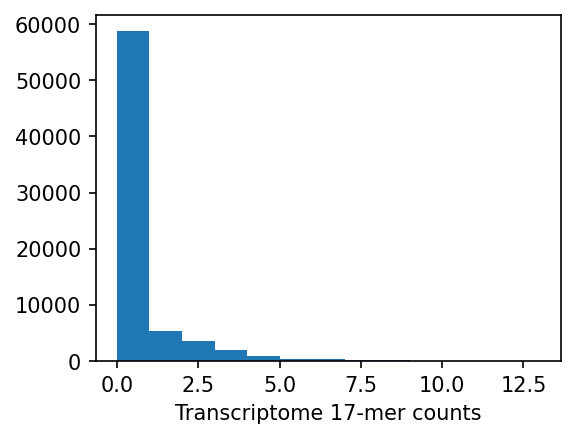

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
ax.hist(final_probe_df['Transcriptome'].values, bins=np.arange(new_count_th))
ax.set_xlabel(f"Transcriptome {table_keylen}-mer counts")
fig.savefig(os.path.join(library_folder, 'final_probe_transcriptome_counts.png'), dpi=300, transparent=True)
plt.show()

# save both

In [17]:
import time
final_probe_filename = os.path.join(library_folder,
    f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_merged_probes.xlsx")
skipped_probe_filename = os.path.join(library_folder,
    f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_skipped_probes.xlsx")
# save
print(f"saving final probes to file: {final_probe_filename}")
final_probe_df.to_excel(final_probe_filename, index=None)
print(f"saving skipped probes to file: {skipped_probe_filename}")
skipped_probes.to_excel(skipped_probe_filename, index=None)

saving final probes to file: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites\IntBC_MERFISH\2023_5_16_merged_probes.xlsx
saving skipped probes to file: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites\IntBC_MERFISH\2023_5_16_skipped_probes.xlsx


In [18]:
# save twist version:
twist_final_probes = pd.DataFrame(
    {
        "name": final_probe_df['Name'].values,
        "sequence": final_probe_df['Sequence'].values,
    }
)
twist_probe_filename = os.path.join(library_folder,
    f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_twist_merged_probes.xlsx")
print(f"saving twist probes to file: {twist_probe_filename}")
twist_final_probes.to_excel(twist_probe_filename, index=None)

saving twist probes to file: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites\IntBC_MERFISH\2023_5_16_twist_merged_probes.xlsx


In [23]:
final_probe_df

,Name,Sequence,Transcriptome,r_t_RNA
0,Library_20ntNO_fwd_W1B05_primer_16_newPE-TS-18...,CGGGTTTCGTTGCGCACACCtGTTGGGCCCTCACAAATACAtTAGA...,2,0
1,Library_20ntNO_fwd_W1B05_primer_16_newPE-TS-18...,CGGGTTTCGTTGCGCACACCtACAATTCACCTTACGTCGTGtATAT...,0,0
2,Library_20ntNO_fwd_W1B05_primer_16_newPE-TS-18...,CGGGTTTCGTTGCGCACACCtATTTACGACTGAACGCAGCAtTAGA...,3,0
3,Library_20ntNO_fwd_W1B05_primer_16_newPE-TS-18...,CGGGTTTCGTTGCGCACACCtGATATAGGGCGAATCCGAACtTGAC...,0,0
4,Library_20ntNO_fwd_W1B05_primer_16_newPE-TS-18...,CGGGTTTCGTTGCGCACACCtTTCAATGCTAGTGCGCCACAtTAGA...,1,0
...,...,...,...,...
71914,Library_30ntNO_fwd_W1A03_primer_2_newPE-TS-180...,CCCGCAATGGCTGACAACCGtGACAGCTCGGGCATAGATCATATGT...,0,0
71915,Library_30ntNO_fwd_W1A03_primer_2_newPE-TS-180...,CCCGCAATGGCTGACAACCGtAGCGTTGGAGTAGCCGGGTTGGAAT...,2,0
71916,Library_30ntNO_fwd_W1A03_primer_2_newPE-TS-180...,CCCGCAATGGCTGACAACCGtAATTCCGTAGTTCGTCCACCGATGC...,0,0
71917,Library_30ntNO_fwd_W1A03_primer_2_newPE-TS-180...,CCCGCAATGGCTGACAACCGtCTCTAGCAGTTCACGCCGAAAGCCC...,0,0


In [32]:
## save primers
fwd_primer_names, rev_primer_names = [],[]

for _n in final_probe_df['Name']:
    fwd_primer_names.append(_n.split('fwd_')[1].split('_newPE')[0])
    rev_primer_names.append('W1'+_n.split('_W1')[-1])
fwd_primer_names = np.unique(fwd_primer_names)
rev_primer_names = np.unique(rev_primer_names)

In [36]:
from ChromAn.src.library_tools.primers import load_fasta_to_DataFrame
primer_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References\Primers'
# fwd
forward_primers = load_fasta_to_DataFrame(os.path.join(primer_folder, 'forward_primers_keep.fasta'))
reverse_primers = load_fasta_to_DataFrame(os.path.join(primer_folder, 'reverse_primers_keep.fasta'))

In [40]:
used_fwd_primers = pd.DataFrame([_row for _i, _row in forward_primers.iterrows() if _row['Name'] in fwd_primer_names])

In [44]:
used_rev_primers = pd.DataFrame([_row for _i, _row in reverse_primers.iterrows() if _row['Name'] in rev_primer_names])

In [50]:
primers = pd.concat([used_fwd_primers, used_rev_primers])
primers['Scale'] = '25nm'
primers['Purification'] = 'STD'
# save
primer_filename = os.path.join(library_folder, 
                               f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_primers.xlsx")
primers.to_excel(primer_filename, index=None)

In [51]:
primers

,Name,Sequence,Scale,Purification
1,W1A03_primer_2,CCCGCAATGGCTGACAACCG,25nm,STD
3,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,25nm,STD
8,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,25nm,STD
4,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,25nm,STD
5,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,25nm,STD
6,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,25nm,STD


In [45]:
used_rev_primers

,Name,Sequence
4,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG
5,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG
6,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA


In [34]:
fwd_primer_names, rev_primer_names

(array(['W1A03_primer_2', 'W1A07_primer_6', 'W1B05_primer_16'],
       dtype='<U15'),
 array(['W1A10_primer_9', 'W1A12_primer_11', 'W1B04_primer_15'],
       dtype='<U15'))